## Problem set: Week 7 (Resting fMRI)
In this problem set you will load the correlation data from one of the Midnight Scan Club subjects (which has already been extracted using the Glasser MMP parcellation) and perform several analyses to characterize the network.

As before, skeletal code is provided - please fill in any areas where you see ...


In [1]:
import os,pickle,sys
import numpy,pandas
import nilearn.datasets
import nilearn.plotting
import matplotlib.pyplot as plt
import scipy.stats
import scipy.spatial.distance
import networkx as nx
import sklearn.metrics
import bct
from collections import Counter

from brainnetworks.r2z import r_to_z,z_to_r
%matplotlib inline

datadir = nilearn.datasets.get_data_dirs()[0]
if not os.path.exists(datadir):
    os.mkdir(datadir)
    
atlasdir='/home/vagrant/brain-networks-course/data/HCP-MMP1'

labelfile=os.path.join(atlasdir,'MMP_yeo2011_networks.csv')
labeldata=pandas.read_csv(labelfile)
labeldata = labeldata.rename(columns={labeldata.columns[0]: 'Index'})


In [2]:
# first load the data

sub=1
corrtype='gsr'  # use data with global signal regression
scrubtype='full' # don't use scrubbing


subdir=os.path.join(datadir,'MSC/ds000224/derivatives/fmriprep/sub-MSC%02d/'%sub)

corrs=pickle.load(open(os.path.join(subdir,'sub-MSC%02d_task-rest_corrmtx.pkl'%sub),'rb'))



Now compute the mean correlation matrix across sesssions, using the r-to-z transform to first convert them to Z scores and then convert back to r values after averaging. The correlation data are stored in a dictionary, with the following key structure:

> ```corrs[session num][corrtype:{'gsr','nogsr'}][scrubtype:{'scrubbed','full'}]```

We will use corrtype and scrubtype as specified above

In [3]:
corrsum=numpy.zeros(corrs[1][corrtype][scrubtype].shape)
for s in corrs:
    sesscor=corrs[s][corrtype][scrubtype]
    corrsum+=r_to_z(sesscor)
    
meancorr=z_to_r(corrsum/len(corrs))
    



/home/vagrant/miniconda3/envs/py3/lib/python3.6/site-packages/brainnetworks/r2z.py:9: RuntimeWarning: divide by zero encountered in true_divide
  z=0.5*numpy.log((1.0+r)/(1.0-r))


**Problem 1**: Create a binary adjacency matrix with a density of 5%, and use this to create a NetworkX graph.  Be sure to do the following:

- exclude the diagonal when computing the cutoff 
- zero out the diagonal before creating the graph
- extract the giant component from the graph (calling the resulting variable ```Gc```)
- print the number of nodes in the giant component

In [4]:
# determine cutoff for 5% density of the correlation matrix
# using just the upper triangle of the matrix
thresh = 95  # in percent
cutoff = numpy.percentile(scipy.spatial.distance.squareform(meancorr, checks=False), thresh)

#create symmetric binary adjacency matrix
# be sure to convert to integer
adjmtx = meancorr >= cutoff

# zero out the diagonal in the adjmtx
adjmtx[numpy.eye(len(adjmtx), dtype='bool')] = 0
adjmtx.dtype = 'uint8'

# Create numpy graph
G = nx.from_numpy_matrix(adjmtx)

# create graph for giant component
# first get all component subgraphs
comps = nx.connected_component_subgraphs(G)
# then take the largest
Gc = max(comps, key=len)

adjmtxc = nx.to_numpy_array(Gc)

print('Giant component includes %d out of %d total nodes'%(len(Gc.nodes),len(G.nodes)))

# grab the label data for only the nodes in the giant component
labeldata_Gc=labeldata.loc[list(Gc.nodes)]
# add degree values to labeldata frame
labeldata_Gc['degree']=[Gc.degree[i] for i in labeldata_Gc.index]




Giant component includes 356 out of 360 total nodes


**Problem 3**: Perform community detection on the graph, using the Louvain algorithm for undirected binary graphs as implemented in the bct python package, and compute their overlap with the Yeo 7 network parcellation



In [5]:
# compute modularity using bct
mod_binary = bct.modularity_louvain_und(adjmtxc)

print('modularity:',mod_binary[1])
print('Multilevel modularity optimization identifed %d communities'%len(numpy.unique(mod_binary[0])))

# compute adjusted rand score using method from sklearn.metrics
ari = sklearn.metrics.adjusted_rand_score(mod_binary[0],labeldata_Gc['Yeo7'])
print('Adjusted Rand index compared to Yeo 7 networks: %0.3f'%ari)



modularity: 0.6551246766923762
Multilevel modularity optimization identifed 7 communities
Adjusted Rand index compared to Yeo 7 networks: 0.400


**Problem 4**: Estimate the normalized rich club coefficient for this network and plot the coefficients across the range of degree values.  Find the smallest degree value  for which the rich club coefficient is greater than 2, which we will use to define the rich club nodes.

degree_cutoff: 35
43 nodes in rich club


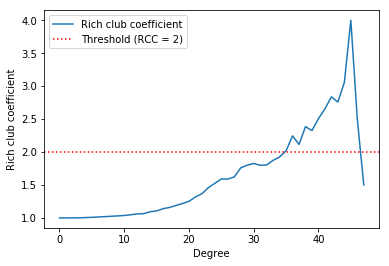

In [6]:
# embed computation of rcc within a try/catch since it fails
# pretty regularly with a ZeroDivisionError
good_rcc=False
while not good_rcc:
    try:
        rcc = nx.rich_club_coefficient(Gc)
        good_rcc=True
    except ZeroDivisionError:
        print('error, retrying')
        
# put into a data frame
rccdata=pandas.DataFrame([(i,rcc[i]) for i in rcc.keys()],
                         columns=['degree','rcc'])

# find the degree cutoff for rcc >= 2
degree_cutoff = rccdata.loc[rccdata['rcc']>=2]['degree'].iloc[0]
print('degree_cutoff:',degree_cutoff)

# compute the size of the rich club
rc_size = len(labeldata_Gc.loc[labeldata_Gc['degree']>=degree_cutoff])
print(rc_size,'nodes in rich club')

# Plot
plt.plot(rccdata['degree'], rccdata['rcc'], label='Rich club coefficient')
plt.axhline(y=2, linestyle=':', color='red', label='Threshold (RCC = 2)')
plt.ylabel('Rich club coefficient')
plt.xlabel('Degree')
plt.legend()

**Problem 5:** For each of the Yeo7 networks, determine how many rich club members fall within that network.

In [7]:
# first create a data frame containing label data just for rcc members

labeldata_rcc = labeldata_Gc.loc[labeldata_Gc['degree']>=degree_cutoff]

# use collections.Counter to generate a list of the counts of members in each
# Yeo7 network
c = dict(Counter(labeldata_rcc['YeoDesc7']))
print(c)

{'Visual': 21, 'DorsalAttention': 6, 'VentralAttention': 13, 'Default': 2, 'Somatomotor': 1}


**Problem 6:** First, compute the node betweenness centrality and edge betweeness centrality for the giant component network.  

In [8]:
# compute edge betweenness centrality
ebc = nx.edge_betweenness_centrality(Gc)

# compute node betweenness centrality
bc = nx.betweenness_centrality(Gc)

Then, compute the mean betweenness centrality for edges separated by whether they include 0, 1, or 2 members of the rich club, and print out the mean values for each.

In [9]:
def is_rc(node):
    return node in labeldata_rcc['Index']

rce = {}
for i in range(3):
    rce[i] = [ebc[j] for j in ebc if sum([is_rc(j[0]), is_rc(j[1])])==i]
    print('Mean betweenness centrality for edges incident on {} rich-club nodes: {}'.format(i, numpy.mean(rce[i])))

Mean betweenness centrality for edges incident on 0 rich-club nodes: 0.001303639459318467
Mean betweenness centrality for edges incident on 1 rich-club nodes: 0.0010032096606917421
Mean betweenness centrality for edges incident on 2 rich-club nodes: 0.0004747857984713991


Now compute the mean betweenness centrality for nodes, separated by whether the nodes are members of the rich club or not, and print the values for each.

In [10]:
rcn = {}
for i in range(2):
    rcn[i] = [bc[j] for j in bc if sum([is_rc(j)])==i]

print('Mean betweenness centrality for rich-club nodes: {}'.format(numpy.mean(rcn[1])))
print('Mean betweenness centrality for non-rich-club nodes: {}'.format(numpy.mean(rcn[0])))

Mean betweenness centrality for rich-club nodes: 0.012539901048146873
Mean betweenness centrality for non-rich-club nodes: 0.006572179058063817


How does centrality of both nodes and edges relate to rich club membership?  Please explain (insert your answer in the following cell).

Node betweenness centrality appears to be related to rich club membership; the mean betweenness centrality of rich-club nodes is approximately twice that of non-rich-club nodes. The rich club constitutes nodes of high degree with a large number of mutual connections. Betweenness centrality measures the extent to which shortest paths between every pair of nodes pass through a particular node or edge. Intuitively, it might be expected that shortest paths would frequently traverse a highly interconnected rich club of nodes.

Curiously, edge betweenness centrality did not appear to be positively related to rich club membership; in particular, edges that connected rich club nodes to one another less frequently participated in shortest paths than did other edges. This suggests that shortest paths traverse the rich club but only infrequently remain inside the rich club. This can potentially be ascribed to some redundancy between the edges of the highly connected rich club nodes. In other words: while there are many parallel (redundant) pathways across the rich club, there are fewer pathways in the network's periphery, and shortest paths in the periphery are consequently more restricted in terms of which edges they can traverse.